# Assignment 2

Use this notebook to write your code for assignment 2

# Pre-processing data

Read the data file of `shakespeare.txt` and prepare the inputs/outputs to your model.

In [1]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math

In [2]:
all_characters = string.printable # list of all possible characters (from string)
num_characters = len(all_characters) # number of possible characters

text = unidecode.unidecode(open('./data/shakespeare.txt').read())

text_len = len(text) 

sequence_len = 40

def generate_sequence():
    start_index = random.randint(0, text_len - sequence_len)
    end_index = start_index + sequence_len + 1
    return text[start_index:end_index]


# Build the Model

Implement a character-based LSTM model 

In [3]:
class CharNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(CharNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self): 
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

In [4]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)


# Training

The main training routine

In [5]:
def generate_training_set():    
    
    sequence = generate_sequence()
    inp = char_tensor(sequence[:-1])
    target = char_tensor(sequence[1:])
    
    return inp, target

In [6]:

def evaluate_CharNN(character_seed='A', predict_len=100, temperature=0.8):
    
    hidden = decoder.init_hidden()
    seed_input = char_tensor(character_seed)
    predicted_string = character_seed

    for p in range(len(character_seed) - 1):
        _, hidden = decoder(seed_input[p], hidden)
    inp = seed_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        output_distribution = output.data.view(-1).div(temperature).exp()
        top_character = torch.multinomial(output_distribution, 1)[0]
        predicted_char = all_characters[top_character]
        predicted_string += predicted_char 
        inp = char_tensor(predicted_char) 
        
    return predicted_string

In [7]:

def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()

    loss = 0

    for c in range(sequence_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, torch.LongTensor([target[c]]))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / sequence_len

In [8]:
def runtime(instant):
    seconds = time.time() - instant
    minutes= math.floor(seconds / 60)
    seconds -= minutes * 60
    return '%dm %ds' % (minutes, seconds)

In [9]:
num_epochs = 3000
print_every = 500 
plot_every = 10 
hidden_size = 200
num_layers = 1
learning_rate = 0.005

decoder = CharNN(num_characters, hidden_size, num_characters, num_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = [] 
loss_avg = 0

for epoch in range(1, num_epochs + 1):
    loss = train(*generate_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[Runtime: %s, Epoch: %d (%d%%), Loss: %.4f]' % (runtime(start), epoch, epoch / num_epochs * 100, loss))
        print(evaluate_CharNN('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every) 
        loss_avg = 0

[Runtime: 0m 17s, Epoch: 500 (16%), Loss: 1.2391]
Whuietir, therou my spiatty sucets,
Prit evearn that of mave,
               An that ham move of areir 

[Runtime: 0m 36s, Epoch: 1000 (33%), Loss: 1.6342]
Whingifure marte gleauty his simy hear betill with are shay doth my arturs be this of will beove of sh 

[Runtime: 0m 55s, Epoch: 1500 (50%), Loss: 1.8591]
When me,
  And may der fere to ad witth Thoth shat strese walssee:
  in ed swe oring (bt.


           

[Runtime: 1m 13s, Epoch: 2000 (66%), Loss: 1.7188]
Whove make alts thou thou grettaked,
And storest,
  Thate him craing my as groundst that.
  I his I su 

[Runtime: 1m 31s, Epoch: 2500 (83%), Loss: 1.8760]
Whier my fork reddar gived it sing sould
And their woron is infe thee, a dome that co thinks my shal b 

[Runtime: 1m 50s, Epoch: 3000 (100%), Loss: 1.8408]
Which eyes not hid mad that true, ris, thou every they deef a ver my will dead coming a hide no love,
 



# Plotting the Training Losses

Plotting the historical loss during training:

Text(0, 0.5, 'Loss')

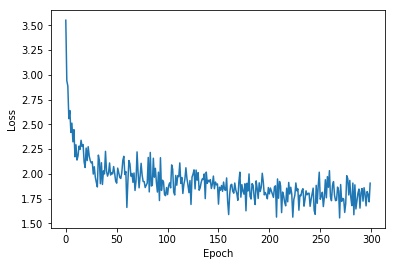

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Plot Loss function using "all_losses"
plt.figure()
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')


# Evaluating at different "temperatures"

Changing the `temperature` argument (variance) for 1.5, 0.75. 0.25 and sample outputs from the trained model.

In [11]:
print(evaluate_CharNN('Shall I compare thee to a summer''s day?\n', 300, temperature=1.5))

Shall I compare thee to a summers day?
The's of
nourit thy lovn, oldasts,
8
Y chimeiming
  0aptn,
  Made.
Ssadd
By I  69
Th9
Cafou
Sech,
Thouty hime tel miakes,
Nar ofe.
  O n' thate hveoss hight,
Whas afevar, uwe
NordsAVewafcamixay:
Pir'.
Bown of came nar ndie;,
  The no theize.
A(beuke yle bartue folefeled .
Whqatre thinlsein desi's th


In [12]:
print(evaluate_CharNN('Shall I compare thee to a summer''s day?\n', 300, temperature=0.75))

Shall I compare thee to a summers day?
Or a a weake dvite, and decon mise that thy wore disdaidie thee his a make, thy tree ath,
Thou knowfer and this sided perseathers thee thee forld as will be which his deecons sendied sway devisess)
And beauty lie thy will this and at this hined and may to pate,
That till but.
That writer thy theee h


In [13]:
print(evaluate_CharNN('Shall I compare thee to a summer''s day?\n', 300, temperature=0.25))

Shall I compare thee to a summers day?
When this thee be thee that thee thee,
That thee,
That thee thou that thou say thee thou such summer thou mand thee that summer with with thee thee,
That thou a thee thee,
What thee thou thou that thou make thou make thee thee but thee,
Thee thee thee thee thee thee thou will thou summer will that t
